In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore') 

start = time.perf_counter()

In [2]:
df = pd.read_csv('earl694412-infinite-matchhistory.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 865 entries, 0 to 864
Data columns (total 47 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               865 non-null    object 
 1   SeasonNumber       865 non-null    int64  
 2   SeasonVersion      865 non-null    int64  
 3   Player             865 non-null    object 
 4   MatchId            865 non-null    object 
 5   Map                865 non-null    object 
 6   Category           865 non-null    object 
 7   Playlist           865 non-null    object 
 8   Input              865 non-null    object 
 9   Queue              865 non-null    object 
 10  PreCsr             865 non-null    int64  
 11  PostCsr            865 non-null    int64  
 12  Rank               865 non-null    int64  
 13  WasAtStart         865 non-null    int64  
 14  WasAtEnd           865 non-null    int64  
 15  WasInProgressJoin  865 non-null    int64  
 16  Mmr                2 non-n

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df['LengthMinutes'] = df['LengthSeconds'] / 60
df.rename(columns={'TotalKills': 'Kills'}, inplace=True)
df['DamageRatio'] = df['DamageDone'] / df['DamageTaken']
df['KillsBody'] = df['Kills'] - df['KillsGrenade'] - df['KillsHeadshot'] - df['KillsMelee'] - df['KillsPower']
## Per 10 Mins and Excess
df['Kills/10Min'] = (df['Kills'] / df['LengthMinutes']) * 10
df['Deaths/10Min'] = (df['Deaths'] / df['LengthMinutes']) * 10
df['Assists/10Min'] = (df['Assists'] / df['LengthMinutes']) * 10
df['Dmg/10Min'] = (df['DamageDone'] / df['LengthMinutes']) * 10
df['DmgT/10Min'] = (df['DamageTaken'] / df['LengthMinutes']) * 10
df['ExcessKills'] = df['Kills'] - df['ExpectedKills']
df['ExcessDeaths'] = df['ExpectedDeaths'] - df['Deaths']

## Lifetime
df['LifetimeKD'] = df['Kills'].cumsum() / df['Deaths'].cumsum()
df['LifetimeDmgRatio'] = df['DamageDone'].cumsum() / df['DamageTaken'].cumsum()
df['LifetimeAcc'] = df['ShotsLanded'].cumsum() / df['ShotsFired'].cumsum() * 100
df['LifetimeBodyPct'] = df['KillsBody'].cumsum() / df['Kills'].cumsum() *100
df['LifetimeMeleePct'] = df['KillsMelee'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimeHSPct'] = df['KillsHeadshot'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimeGrenadePct'] = df['KillsGrenade'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimePowerPct'] = df['KillsPower'].cumsum() / df['Kills'].cumsum() * 100

df['Map'] = df['Map'].str.replace(' - Ranked', '')

df = df.drop(['Player', 'MatchId', 'Input', 'Queue', 'Mmr', 'WasAtStart', 'WasAtEnd',
            'WasInProgressJoin', 'AssistsEmp', 'AssistsDriver', 'AssistsCallout', 'VehicleDestroys',
            'VehicleHijacks', 'Perfects', 'PreCsr', 'SeasonNumber', 'SeasonVersion'],axis=1)
dfr = df[df['Date']> '2023-01-01']
dfr = dfr[dfr['Playlist'] == 'Ranked Arena']
dfr['Csr'] = dfr['PostCsr'].replace(0, method='ffill')
dfr = dfr[dfr['Outcome'] != 'Draw']
dfr = dfr[dfr['Outcome'] != 'Left']
dfr['Outcome'] = dfr['Outcome'].map({'Win': 1, 'Loss': 0})
dfr['LifetimeWinRate'] = (dfr['Outcome'].cumsum() / 
                          (dfr['Outcome'].cumsum() + 
                           dfr['Outcome'].eq(0).cumsum())).fillna(0)
dfr = dfr.drop(['Playlist', 'PostCsr'], axis=1).reset_index()
# dfr.loc[:4, 'Csr'] = 808
dfr.to_csv('df.csv')
dfr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Data columns (total 49 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   index               605 non-null    int64         
 1   Date                605 non-null    datetime64[ns]
 2   Map                 605 non-null    object        
 3   Category            605 non-null    object        
 4   Rank                605 non-null    int64         
 5   Outcome             605 non-null    int64         
 6   Accuracy            605 non-null    float64       
 7   DamageDone          605 non-null    int64         
 8   DamageTaken         605 non-null    int64         
 9   ShotsFired          605 non-null    int64         
 10  ShotsLanded         605 non-null    int64         
 11  ShotsMissed         605 non-null    int64         
 12  KD                  605 non-null    float64       
 13  KDA                 605 non-null    float64       

In [4]:
dfr.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
index,605.0,502.674380,209.496380,140.000000,322.000000,498.000000,684.000000,864.000000
Rank,605.0,3.961983,2.140792,1.000000,2.000000,4.000000,5.000000,8.000000
Outcome,605.0,0.553719,0.497517,0.000000,0.000000,1.000000,1.000000,1.000000
Accuracy,605.0,51.887868,5.452473,24.390000,48.590000,52.040000,55.020000,80.560000
DamageDone,605.0,5234.927273,1851.141543,347.000000,3883.000000,5025.000000,6448.000000,12673.000000
DamageTaken,605.0,4459.416529,1560.272068,35.000000,3448.000000,4279.000000,5498.000000,9962.000000
ShotsFired,605.0,235.249587,80.178560,16.000000,180.000000,227.000000,291.000000,517.000000
ShotsLanded,605.0,121.697521,42.627558,4.000000,94.000000,116.000000,150.000000,286.000000
ShotsMissed,605.0,113.552066,40.935331,7.000000,84.000000,111.000000,140.000000,261.000000
KD,605.0,1.268975,0.750748,0.000000,0.860000,1.130000,1.450000,10.000000


In [5]:
# dfr.tail()
round(dfr.sort_values('Csr', ascending=False),2).head(8)

,index,Date,Map,Category,Rank,Outcome,Accuracy,DamageDone,DamageTaken,ShotsFired,...,LifetimeKD,LifetimeDmgRatio,LifetimeAcc,LifetimeBodyPct,LifetimeMeleePct,LifetimeHSPct,LifetimeGrenadePct,LifetimePowerPct,Csr,LifetimeWinRate
576,831,2024-03-08 01:52:40,Solitude,Slayer,4,1,40.71,2102,2790,140,...,1.12,1.17,50.02,28.33,10.06,51.10,7.04,3.46,1092,0.55
604,864,2024-03-12 02:26:23,Recharge,King of the Hill,2,1,57.48,7993,7000,294,...,1.11,1.16,50.18,28.47,10.09,51.06,7.01,3.38,1091,0.55
575,830,2024-03-07 01:55:14,Aquarius,Slayer,2,1,58.33,4854,4377,192,...,1.12,1.17,50.03,28.32,10.07,51.11,7.03,3.47,1087,0.55
603,863,2024-03-12 02:18:30,Streets,Slayer,4,1,56.64,3898,2923,143,...,1.11,1.16,50.17,28.47,10.08,51.08,6.99,3.38,1085,0.55
600,860,2024-03-12 01:46:54,Streets,Oddball,3,1,66.67,3614,3038,135,...,1.12,1.17,50.16,28.46,10.07,51.09,7.00,3.39,1083,0.55
577,832,2024-03-08 02:06:57,Recharge,Strongholds,5,0,56.37,6465,5906,259,...,1.12,1.17,50.03,28.33,10.07,51.12,7.02,3.46,1083,0.55
574,829,2024-03-07 01:51:02,Live Fire,Strongholds,1,1,71.43,1035,617,35,...,1.12,1.17,50.02,28.29,10.07,51.15,7.02,3.47,1080,0.55
597,857,2024-03-12 01:12:10,Live Fire,Slayer,4,1,60.67,4042,3678,178,...,1.12,1.17,50.15,28.41,10.05,51.13,7.02,3.40,1079,0.55


In [6]:
# dfr.hist(bins=15, figsize=(18, 14))
# plt.tight_layout()
# plt.show()

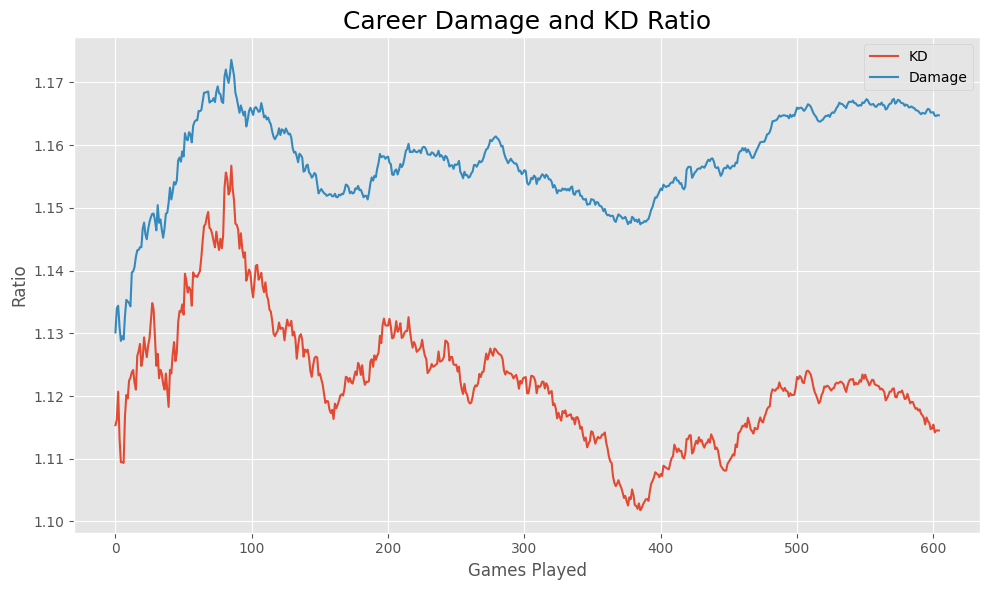

In [7]:
plt.figure(figsize=(10,6))
plt.plot(dfr['LifetimeKD'], label='KD' )
plt.plot(dfr['LifetimeDmgRatio'], label='Damage')
plt.title('Career Damage and KD Ratio', fontsize=18)
plt.xlabel('Games Played')
plt.ylabel('Ratio')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig('Plots/DamKD.png', dpi=300)
plt.show()

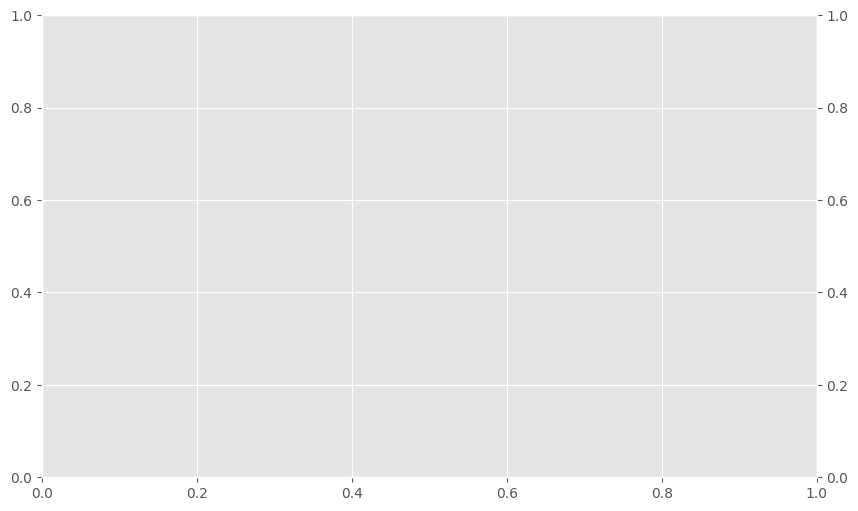

In [8]:
from IPython.display import HTML
from matplotlib import animation

plt.rcParams['animation.embed_limit'] = 300.0

dfr_date = dfr.index
dfr_kd = dfr['LifetimeKD']
dfr_dam = dfr['LifetimeDmgRatio']
dfr_csr = dfr['Csr']

# then assign df_date to x and df_close to y
x = dfr_date
y = dfr_kd
y2 = dfr_dam
y3 = dfr_csr

# calculate min and max x values + 1 and
# the min and max y values times scale factors
min_x = min(x)
max_x = max(x)
min_y = min(min(y), min(y2))
max_y = max(max(y), max(y2))
min_y3 = min(y3)
max_y3 = max(y3)

#########################################################################################
# generate and display animation line plot
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax2 = ax.twinx()

def animate(i):
    ax.cla() # clear the previous image
    ax2.cla()
    plt.title('KD/Damage Ratio and CSR over Time',fontsize=16)
    plt.xlabel('Game Played')
    plt.ylabel('Ratios/CSR')
    ax.plot(x[:i], y[:i], label='KD') # plot the line
    ax.plot(x[:i], y2[:i], label='Damage') # plot the line
    ax2.plot(x[:i], y3[:i], label='CSR', color='black')
    ax.set_xlim([0.99*min_x, 0.99*max_x]) # fix the x axis
    ax.set_ylim([0.99*min_y, 1.01*max_y]) # fix the y axis 
    ax2.set_xlim([0.99*min_x, 0.99*max_x])
    ax2.set_ylim(min_y3, 1.05*max_y3)
    ax.legend(loc='upper right')
#     ax2.legend(loc='lower right')
    
# anim = animation.FuncAnimation(fig, animate, frames = len(x), interval = 15)

# anim.save('Plots/KDDamCSR.gif', writer='imagemagick', fps=60)

# # Save the animation as HTML
# html_output = anim.to_html5_video()
# # Display the HTML animation in the Jupyter Notebook
# HTML(html_output)

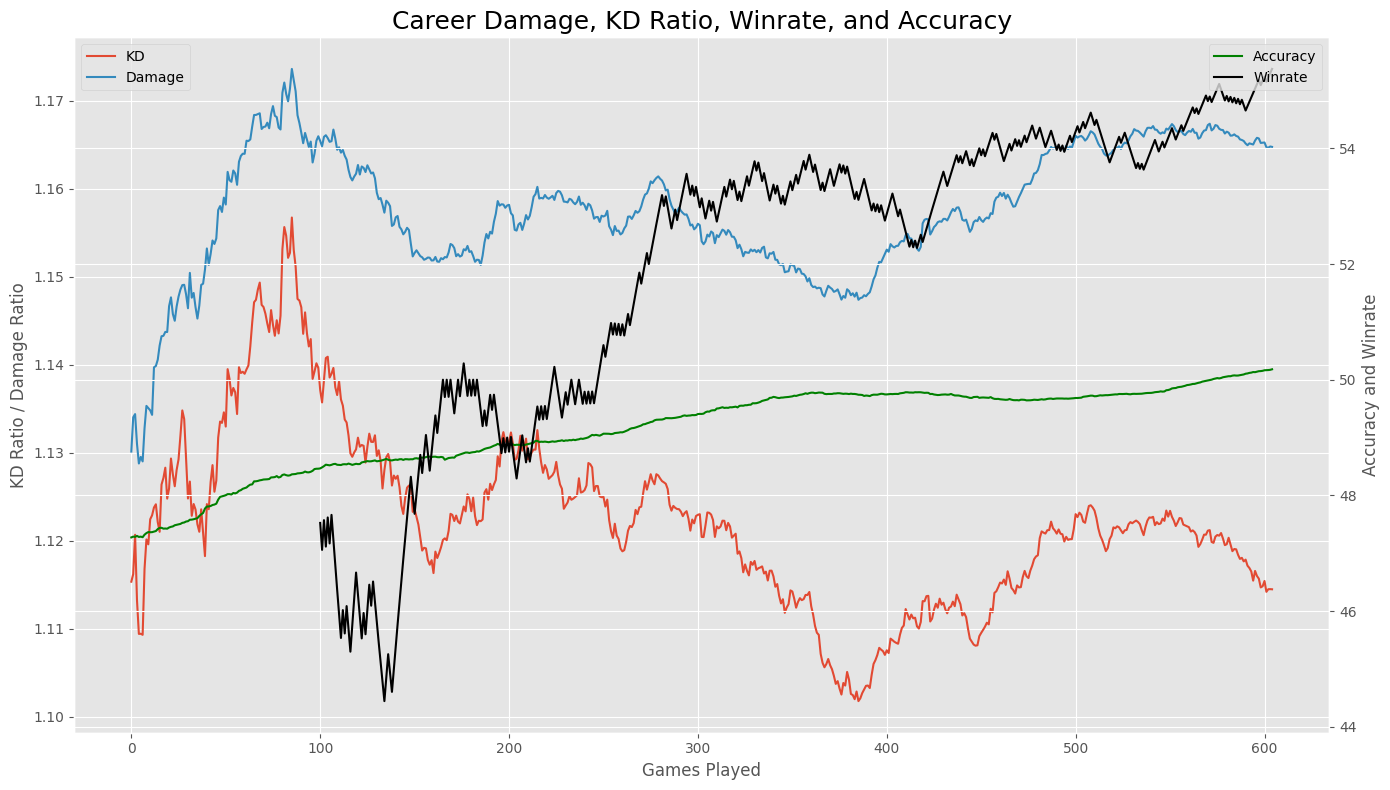

In [9]:
plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeKD'], label='KD' )
ax1.plot(dfr['LifetimeDmgRatio'], label='Damage')
ax2.plot(dfr['LifetimeAcc'], color='green', label='Accuracy')
ax2.plot(dfr['LifetimeWinRate'][100:]*100, color='black', label='Winrate')
ax1.set_title('Career Damage, KD Ratio, Winrate, and Accuracy', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('Accuracy and Winrate')

ax1.yaxis.grid(True)
ax2.yaxis.grid(True)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.savefig('Plots/DamKDWRAcc.png', dpi=300)
plt.show()

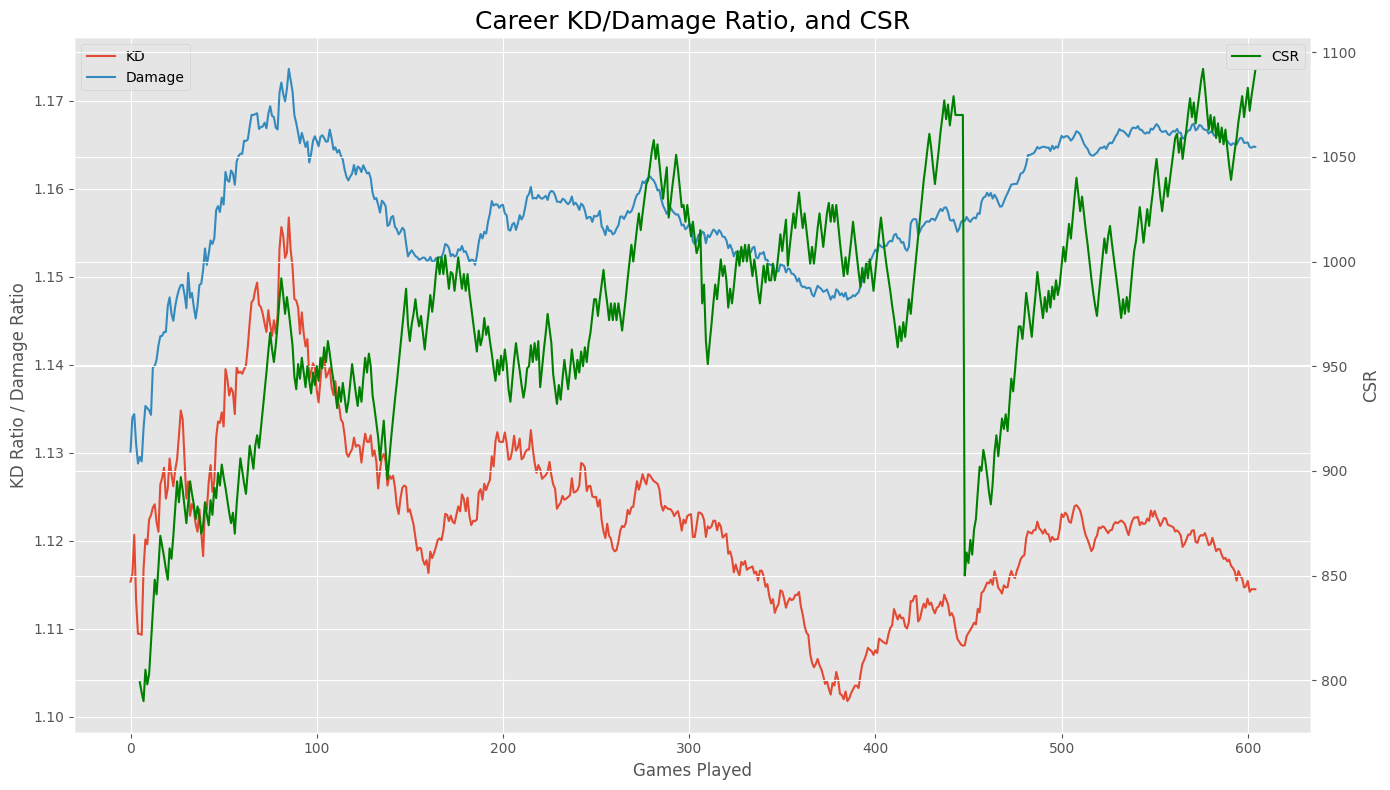

In [10]:
plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeKD'], label='KD' )
ax1.plot(dfr['LifetimeDmgRatio'], label='Damage')
ax2.plot(dfr['Csr'][5:], label='CSR', color='green')
ax1.set_title('Career KD/Damage Ratio, and CSR', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('CSR')
# max_y_value = df['LifetimeAcc'].max()
# ax1.yaxis.grid(True)
# ax2.set_yticks(np.arange(47, max_y_value, 0.5))
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.savefig('Plots/DamKDCsr.png', dpi=300)
plt.show()

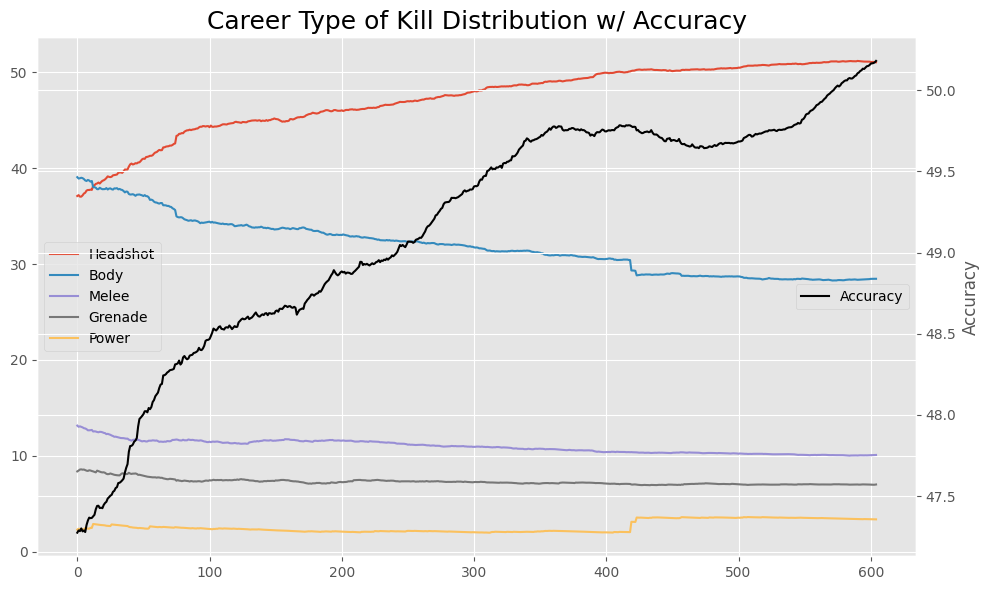

In [11]:
plt.figure(figsize=(10,6))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeHSPct'], label='Headshot')
ax1.plot(dfr['LifetimeBodyPct'], label='Body')
ax1.plot(dfr['LifetimeMeleePct'], label='Melee')
ax1.plot(dfr['LifetimeGrenadePct'], label='Grenade')
ax1.plot(dfr['LifetimePowerPct'], label='Power')
ax2.plot(dfr['LifetimeAcc'], label='Accuracy', color='black')
plt.title('Career Type of Kill Distribution w/ Accuracy', fontsize=18)
plt.xlabel('Games Played')
plt.ylabel('Accuracy')
ax1.legend(loc='best')
ax2.legend(loc='right')
ax1.grid(True, axis='y')
plt.tight_layout()
plt.savefig('Plots/TypeKillAcc.png', dpi=300)
plt.show()

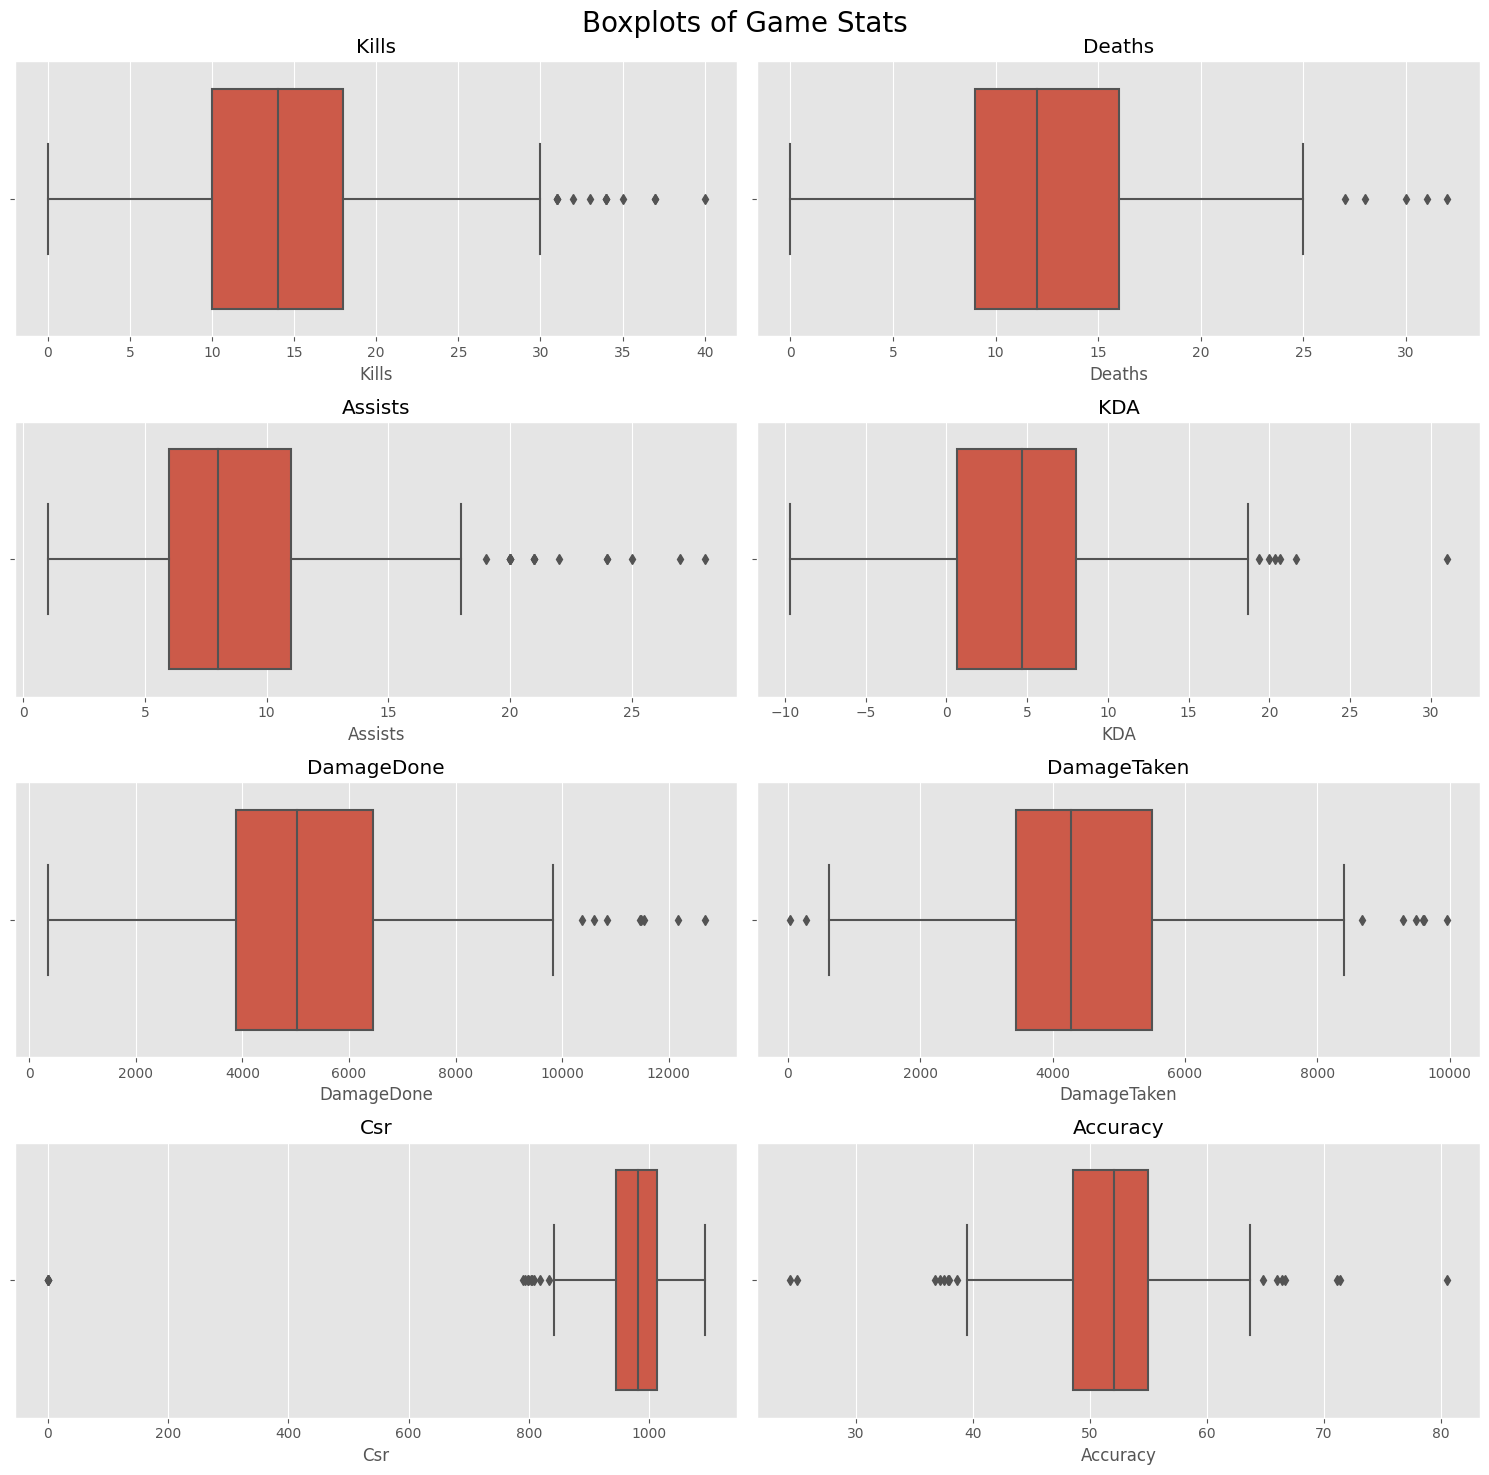

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
columns = ['Kills', 'Deaths', 'Assists', 'KDA', 'DamageDone', 'DamageTaken',
            'Csr', 'Accuracy']

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

# Flatten the axes for easier iteration
axes = axes.flatten()

# Plot each column in a separate boxplot
for i, column in enumerate(columns):
    sns.boxplot(x=dfr[column], ax=axes[i])
    axes[i].set_title(column)

# Adjust layout
plt.suptitle('Boxplots of Game Stats', fontsize=20)
plt.tight_layout()
plt.savefig('Plots/Boxplots.png', dpi=300)
plt.show()


Last * Games stats  
Set mod to however many game you want to view 

In [13]:
# Last * Games

mod = 10
dfmod = dfr.tail(mod)

# dfmod = dfr[dfr['DamageTaken'] < dfr['DamageDone']]
# dfmod1 = dfr[dfr['DamageTaken'] > dfr['DamageDone']]

# print(dfmod.head())
print(f'Overall KD: {round(dfmod["Kills"].sum() / dfmod["Deaths"].sum(),2)}')
print(f"Accuracy: {round(dfmod['ShotsLanded'].sum() / dfmod['ShotsFired'].sum()*100,2)}")
print(f"Damage Ratio: {round(dfmod['DamageDone'].sum() / dfmod['DamageTaken'].sum(),2)}")
print(f"Win-Loss: {(dfmod['Outcome']==1).sum()}-{(dfmod['Outcome']==0).sum()}")
print(f"Winrate: {round((dfmod['Outcome']==1).sum() / (dfmod['Outcome']==0).sum() ,2)}")
print(f"Max CSR: {dfmod['Csr'].max()}")
# dfmod.sort_values('Kills', ascending=False).head(10)



Overall KD: 1.03
Accuracy: 56.03
Damage Ratio: 1.14
Win-Loss: 8-2
Winrate: 4.0
Max CSR: 1091


In [14]:
import plotly.express as px

fig = px.line(df, x=df.index, y=df['Accuracy'].rolling(window=20).mean(), 
              labels={'x': 'Number of Games Played', 'y': 'Accuracy'},
              title='Rolling Avg Accuracy')

fig.show()


In [15]:
dfw = dfr.loc[dfr['Outcome'] == 1, 
                ['Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome', 'ShotsFired', 'ShotsLanded']
                ].sort_values('Kills/10Min', ascending=False)

dfl = dfr.loc[dfr['Outcome'] == 0, 
                ['Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome', 'ShotsFired', 'ShotsLanded']
                ].sort_values('Kills/10Min', ascending=False)

dfmod = dfr[dfr['DamageTaken'] < dfr['DamageDone']]
dfmod1 = dfr[dfr['DamageTaken'] > dfr['DamageDone']]

print('Overall')
print(f'Overall KD: {round(dfr["Kills/10Min"].sum() / dfr["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfr['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfr['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfr['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfr['ShotsLanded'].sum() / dfr['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfr['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfr['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfr['DamageDone'].sum() / dfr['DamageTaken'].sum(),2)}")
print(f"Dmg Done <> Taken: {len(dfmod)}-{len(dfmod1)}")
print(f"Win-Loss: {(dfr['Outcome']==1).sum()}-{(dfr['Outcome']==0).sum()}")
print('----------------------------')
print('Totals')
print(f"Total Games: {dfr.Kills.count()}")
print(f"Total Kills: {dfr.Kills.sum()}")
print(f"Total Deaths: {dfr.Deaths.sum()}")
print(f"Total Assists: {dfr.Assists.sum()}")
print('----------------------------')
print('Wins')
print(f'Overall KD: {round(dfw["Kills/10Min"].sum() / dfw["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfw['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfw['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfw['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfw['ShotsLanded'].sum() / dfw['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfw['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfw['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfw['DamageDone'].sum() / dfw['DamageTaken'].sum(),2)}")
print(f"Wins: {(dfw['Outcome']==1).sum()}")
print('----------------------------')
print('Losses')
print(f'Overall KD: {round(dfl["Kills/10Min"].sum() / dfl["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfl['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfl['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfl['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfl['ShotsLanded'].sum() / dfl['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfl['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfl['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfl['DamageDone'].sum() / dfl['DamageTaken'].sum(),2)}")
print(f"Losses: {(dfl['Outcome']==0).sum()}")

Overall
Overall KD: 1.14
Average Kills: 13.68
Average Deaths: 11.98
Average Assists: 8.07
Average Accuracy: 51.73
Average Damage Done: 5235
Average Damage Taken: 4459
Damage Ratio: 1.17
Dmg Done <> Taken: 472-133
Win-Loss: 335-270
----------------------------
Totals
Total Games: 605
Total Kills: 8817
Total Deaths: 7781
Total Assists: 5165
----------------------------
Wins
Overall KD: 1.32
Average Kills: 14.16
Average Deaths: 10.76
Average Assists: 8.59
Average Accuracy: 52.06
Average Damage Done: 5076
Average Damage Taken: 4108
Damage Ratio: 1.24
Wins: 335
----------------------------
Losses
Overall KD: 0.97
Average Kills: 13.08
Average Deaths: 13.49
Average Assists: 7.43
Average Accuracy: 51.35
Average Damage Done: 5432
Average Damage Taken: 4896
Damage Ratio: 1.11
Losses: 270


In [16]:
# Ranks, 1 = Top Winner, 5 = Top Loser
g1 = dfr[dfr['Rank'] == 1].value_counts().count()
g5 = dfr[dfr['Rank'] == 5].value_counts().count()
g15 = round((g1 + g5) / len(dfr)*100,2)


print('Games Ranked 1:',g1)
print('Games Ranked 5:',g5)
print('MVP %:',g15 )

Games Ranked 1: 124
Games Ranked 5: 137
MVP %: 43.14


## Scorigami
Inspired by NFL, tracks unique statlines and counts if theyve occured before, only shows duplicate records instead of unique

In [17]:
# Create a new column for the combined score in the desired format
dfGami = pd.DataFrame()
dfGami['Kills'] = dfr['Kills']
dfGami['Deaths'] = dfr['Deaths']
dfGami['Assists'] = dfr['Assists']
dfGami['Scorigami'] = dfr['Kills'].astype(str) + '-' + dfr['Deaths'].astype(str) + '-' + dfr['Assists'].astype(str)

# Get unique scorigami scores
scorigami_list = dfGami['Scorigami'].unique()

dfGami = dfGami.sort_values(by=['Kills', 'Deaths', 'Assists'], ascending=False)
# print(dfGami.head())
dfGami.to_csv('Scorigami.csv')

In [18]:
gamiPiv = dfGami.pivot_table(index='Scorigami', aggfunc='size')

gamiPiv = gamiPiv.sort_index()

print("Records with >= 3 Scori:",gamiPiv[gamiPiv.values>2].count())
print(gamiPiv[gamiPiv.values>2].sort_values(ascending=False))


Records with >= 3 Scori: 5
Scorigami
15-8-7      3
19-18-10    3
6-11-8      3
7-12-7      3
8-11-5      3
dtype: int64


In [19]:
dfrc = dfr.groupby('Category').agg({'LengthMinutes': 'sum', 'Category': 'count'})
dfrc.rename(columns={'Category': 'Count'}, inplace=True)
dfrc['Length%'] = round(dfrc['LengthMinutes'] / dfrc['LengthMinutes'].sum() * 100,2)
dfrc['Count%'] = round(dfrc['Count'] / dfrc['Count'].sum() * 100,2)
round(dfrc.sort_values('Length%', ascending=False),2)

,LengthMinutes,Count,Length%,Count%
Category,,,,
Slayer,1216.62,142,19.14,23.47
Oddball,1089.65,90,17.15,14.88
Strongholds,1066.22,90,16.78,14.88
CTF 3 Captures,1043.97,95,16.43,15.70
King of the Hill,943.02,86,14.84,14.21
Extraction,611.85,70,9.63,11.57
CTF 5 Captures,384.02,32,6.04,5.29


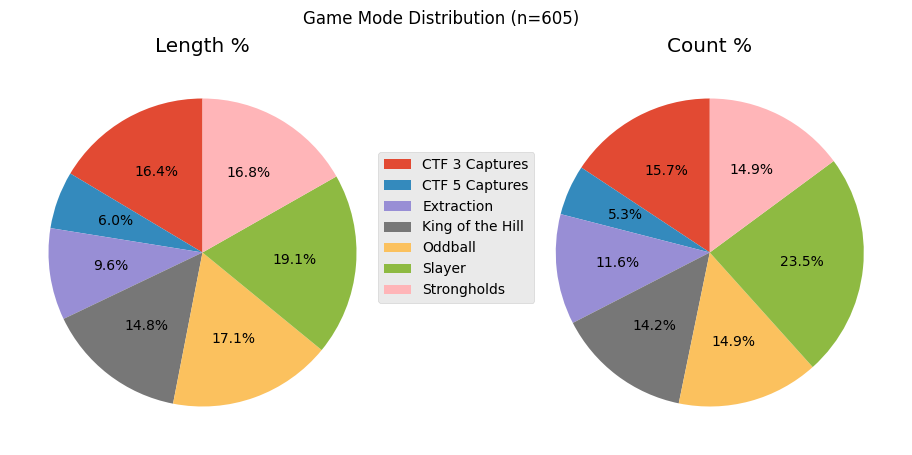

In [20]:
import matplotlib.pyplot as plt

labels = dfrc.index.get_level_values('Category').tolist()
sizes_length = dfrc['Length%'].tolist()
sizes_count = dfrc['Count%'].tolist()
totalcount = dfrc['Count'].sum()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # Create a subplot with 1 row and 2 columns
ax[0].pie(sizes_length, labels=None, autopct='%1.1f%%', startangle=90)
ax[1].pie(sizes_count, labels=None, autopct='%1.1f%%', startangle=90)
fig.suptitle(f'Game Mode Distribution (n={totalcount})')
ax[0].set(aspect="equal", title='Length %')
ax[1].set(aspect="equal", title='Count %')
fig.legend(labels, loc="center")
plt.savefig('Plots/ModeDistro.png', dpi=300)
plt.show()

In [21]:
dfrc = dfr.groupby(['Category','Map']).agg({'Category': 'count', 'LengthMinutes': 'sum', 'Outcome': 'mean'})
dfrc.rename(columns={'Category': 'Count', 'LengthMinutes': 'LengthHours'}, inplace=True)
dfrc['LengthHours'] = round(dfrc['LengthHours']/60,2)
dfrc['Outcome'] = round(dfrc['Outcome'],2)
dfrc['Count%'] = round(dfrc['Count'] / dfrc['Count'].sum() * 100,2)
dfrc['Length%'] = round(dfrc['LengthHours'] / dfrc['LengthHours'].sum() * 100,2)
dfrc = dfrc.sort_values(['Length%'], ascending=False)
dfrc

,,Count,LengthHours,Outcome,Count%,Length%
Category,Map,,,,,
Strongholds,Solitude,40,8.36,0.45,6.61,7.89
King of the Hill,Recharge,41,7.88,0.51,6.78,7.44
Oddball,Streets,36,7.24,0.64,5.95,6.84
CTF 3 Captures,Empyrean,34,6.60,0.41,5.62,6.23
CTF 5 Captures,Aquarius,32,6.40,0.47,5.29,6.04
Slayer,Solitude,42,6.16,0.62,6.94,5.82
CTF 3 Captures,Argyle,32,6.04,0.47,5.29,5.70
Slayer,Aquarius,40,5.67,0.57,6.61,5.35
Oddball,Recharge,28,5.55,0.57,4.63,5.24


In [28]:
dfrcc = dfr.groupby(['Category','Map']).agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'ShotsLanded' : 'sum',
                                             'ShotsFired' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             'LengthMinutes': 'sum',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['Accuracy'] = (dfrcc['ShotsLanded'] / dfrcc['ShotsFired']) *100
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['Dmg/KA'] = dfrcc['DamageDone'] / (dfrcc['Kills'] + dfrcc['Assists'])
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Kills/10Min'] = dfrcc['Kills'] / dfrcc['LengthMinutes'] * 10
dfrcc['Deaths/10Min'] = dfrcc['Deaths'] / dfrcc['LengthMinutes'] * 10
dfrcc['Assists/10Min'] = dfrcc['Assists'] / dfrcc['LengthMinutes'] * 10
dfrcc['KDA/10Min'] = (dfrcc['Kills/10Min'] + (dfrcc['Assists/10Min'] / 3)) / dfrcc['Deaths/10Min'] 
dfrcc = dfrcc.drop(['ShotsLanded', 'ShotsFired'], axis=1)
dfrcc = round(dfrcc.sort_values(['Winrate', 'Category', 'Map'], ascending=False),2)
# dfrcc = round(dfrcc.sort_values('Winrate', ascending=False),2)
dfrcc

Count  Kills  Deaths  Assists  DamageDone  \
Category         Map                                                    
King of the Hill Live Fire     23    333     309      167      112699   
CTF 3 Captures   Forbidden     29    382     283      186      138082   
Oddball          Streets       36    635     561      382      221458   
Slayer           Streets       24    214     218      162       88763   
                 Solitude      42    448     446      292      173771   
                 Recharge      13    125     118       84       52217   
Oddball          Live Fire     26    412     435      291      159452   
Extraction       Recharge      18    230     193      143       80159   
                 Streets       33    453     351      253      147191   
Slayer           Aquarius      40    416     402      262      164652   
Oddball          Recharge      28    467     390      297      168100   
Slayer           Live Fire     23    237     229      132       86791   
King of the Hill Solitude      22    391     315      226      130584   
Strongholds      Live Fire     26    414     343      185      141389   
King of the Hill Recharge      41    702     625      495      257299   
CTF 5 Captures   Aquarius      32    604     461      310      209780   
CTF 3 Captures   Argyle        32    469     403      224      167860   
Strongholds      Solitude      40    771     647      463      261117   
Extraction       Live Fire     19    230     216      125       82363   
Strongholds      Recharge      24    356     343      223      133296   
CTF 3 Captures   Empyrean      34    528     493      263      190108   

                            DamageTaken  Winrate  LengthMinutes  Accuracy  \
Category         Map                                                        
King of the Hill Live Fire       101705     0.78         219.80     53.65   
CTF 3 Captures   Forbidden       104192     0.66         285.43     52.15   
Oddball          Streets         188658     0.64         434.47     53.89   
Slayer           Streets          78925     0.62         190.85     49.40   
                 Solitude        158862     0.62         369.72     49.93   
                 Recharge         46598     0.62         116.53     47.31   
Oddball          Live Fire       139646     0.62         322.12     52.37   
Extraction       Recharge         66596     0.61         165.43     51.43   
                 Streets         118482     0.61         284.25     54.27   
Slayer           Aquarius        146617     0.57         340.22     51.10   
Oddball          Recharge        138799     0.57         333.07     50.33   
Slayer           Live Fire        81976     0.57         199.30     50.44   
King of the Hill Solitude        107965     0.55         250.23     52.23   
Strongholds      Live Fire       123367     0.54         289.20     53.56   
King of the Hill Recharge        216561     0.51         472.98     50.75   
CTF 5 Captures   Aquarius        163115     0.47         384.02     52.39   
CTF 3 Captures   Argyle          138635     0.47         362.30     50.44   
Strongholds      Solitude        218865     0.45         501.55     53.09   
Extraction       Live Fire        72351     0.42         162.17     55.24   
Strongholds      Recharge        116330     0.42         275.47     48.86   
CTF 3 Captures   Empyrean        169702     0.41         396.23     51.51   

                              KD  DamageRatio  Dmg/Life  Dmg/KA  ExDmg/Life  \
Category         Map                                                          
King of the Hill Live Fire  1.08         1.11    364.72  225.40       35.58   
CTF 3 Captures   Forbidden  1.35         1.33    487.92  243.10      119.75   
Oddball          Streets    1.13         1.17    394.76  217.76       58.47   
Slayer           Streets    0.98         1.12    407.17  236.07       45.13   
                 Solitude   1.00         1.09    389.62  234.83       33.43   
                 Rechar

In [23]:
dfrcc = dfr.groupby('Category').agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Assists/Life'] = dfrcc['Assists'] / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Assists/Life', ascending=False),2)
dfrcc

,Count,Kills,Deaths,Assists,DamageDone,DamageTaken,Winrate,KD,DamageRatio,Dmg/Life,ExDmg/Life,Assists/Life
Category,,,,,,,,,,,,
King of the Hill,86,1426,1249,888,500582,426231,0.59,1.14,1.17,400.79,59.53,0.71
Oddball,90,1514,1386,970,549010,467103,0.61,1.09,1.18,396.11,59.10,0.70
Extraction,70,913,760,521,309713,257429,0.56,1.20,1.20,407.52,68.79,0.69
CTF 5 Captures,32,604,461,310,209780,163115,0.47,1.31,1.29,455.05,101.23,0.67
Slayer,142,1440,1413,932,566194,512978,0.60,1.02,1.10,400.70,37.66,0.66
Strongholds,90,1541,1333,871,535802,458562,0.47,1.16,1.17,401.95,57.94,0.65
CTF 3 Captures,95,1379,1179,673,496050,412529,0.51,1.17,1.20,420.74,70.84,0.57


In [24]:
dfrcc = dfr.groupby('Map').agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Assists/Life'] = dfrcc['Assists'] / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Assists/Life', ascending=False),2)
dfrcc

,Count,Kills,Deaths,Assists,DamageDone,DamageTaken,Winrate,KD,DamageRatio,Dmg/Life,ExDmg/Life,Assists/Life
Map,,,,,,,,,,,,
Recharge,124,1880,1669,1242,691071,584884,0.53,1.13,1.18,414.06,63.62,0.74
Streets,93,1302,1130,797,457412,386065,0.62,1.15,1.18,404.79,63.14,0.71
Solitude,104,1610,1408,981,565472,485692,0.54,1.14,1.16,401.61,56.66,0.70
Aquarius,72,1020,863,572,374432,309732,0.53,1.18,1.21,433.87,74.97,0.66
Forbidden,29,382,283,186,138082,104192,0.66,1.35,1.33,487.92,119.75,0.66
Live Fire,117,1626,1532,900,582694,519045,0.59,1.06,1.12,380.35,41.55,0.59
Argyle,32,469,403,224,167860,138635,0.47,1.16,1.21,416.53,72.52,0.56
Empyrean,34,528,493,263,190108,169702,0.41,1.07,1.12,385.61,41.39,0.53


In [25]:
print(f'Runtime: {time.perf_counter() - start}s')

Runtime: 5.533790375004173s
